In [1]:
# reload modules automatically:
%load_ext autoreload
%autoreload 2

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from dataset import split_dataset, BoneAgeDataset, normalize_target
from transforms import get_transform
from model import m46, convert_checkpoint
from train import get_parser, main
from const import DATA_PATH, MODELS_DIR

import torch
from torch.utils.data import DataLoader
from catalyst.dl.runner import SupervisedRunner

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from IPython.core.display import Image, display

Downloading the dataset
-----------------------------------

In [ ]:
!! [ ! -f ../bone-age.zip ] && wget http://data.neu.ro/bone-age.zip -O ../bone-age.zip

In [ ]:
!! unzip ../bone-age.zip -d ../

## Explore the data

In [2]:
bone_age_frame = pd.read_csv(DATA_PATH / 'train.csv') # ground truth
image_root = DATA_PATH / 'train' # radiographs root

* ### Analize gender distribution

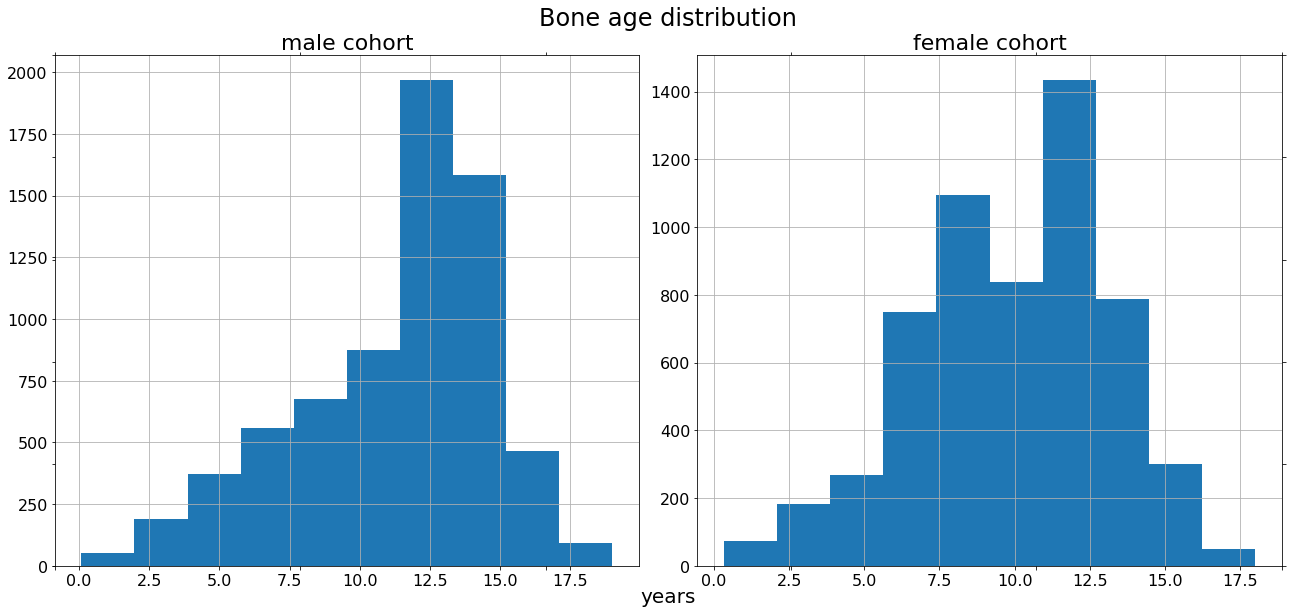

In [3]:
bone_age_frame['boneage_years'] = bone_age_frame['boneage'] / 12
fig = plt.figure(figsize=(18, 8))
for i, gender in enumerate(['male', 'female'], 1):
    ax = plt.subplot(1, 2, i)
    bone_age_frame.loc[bone_age_frame['male'] == (gender == 'male')].hist('boneage_years', ax=ax)
    ax.set_title(f'{gender} cohort', fontsize=22)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
plt.tight_layout()
ax = fig.add_subplot(111, frameon=False)
ax.set_title('Bone age distribution', pad=30, fontsize=24)
ax.set_xlabel('years', fontsize=20)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

* ### Plot some radiographs

In [4]:
def plot_radiographs(dataset, nimages, predictions=None):
    ncols = 4
    nrows = int(np.ceil(nimages / ncols))
    fig = plt.figure()
    for i, sample in enumerate(islice(dataset, nimages), 1):
        image, label, img_id = sample['image'], sample['label'], sample['id']
        if torch.is_tensor(image):
            image = np.squeeze(image.numpy())
            label = normalize_target(label.item(), reverse_norm=True)

        ax = plt.subplot(nrows, ncols, i)
        if predictions is not None:
            ax.set_title(f'id {img_id}, true {label:n}, pred {int(predictions[i - 1]):n}', fontsize=24)
        else:
            ax.set_title(f'id {img_id}, {label:n} months', fontsize=24)
        ax.axis('off')
        ax.imshow(image, cmap='Greys_r')

    figsize = 6
    aspect_ratio = image.shape[0] / image.shape[1]
    fig.set_figheight(aspect_ratio * nrows * figsize)
    fig.set_figwidth(ncols * figsize)
    plt.tight_layout()
    
    ax = fig.add_subplot(111, frameon=False)
    crop_sz = 'x'.join(map(str, image.shape))
    ax.set_title(f'Crop size {crop_sz}', pad=40, fontsize=28)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.pause(0.001)
    plt.show()

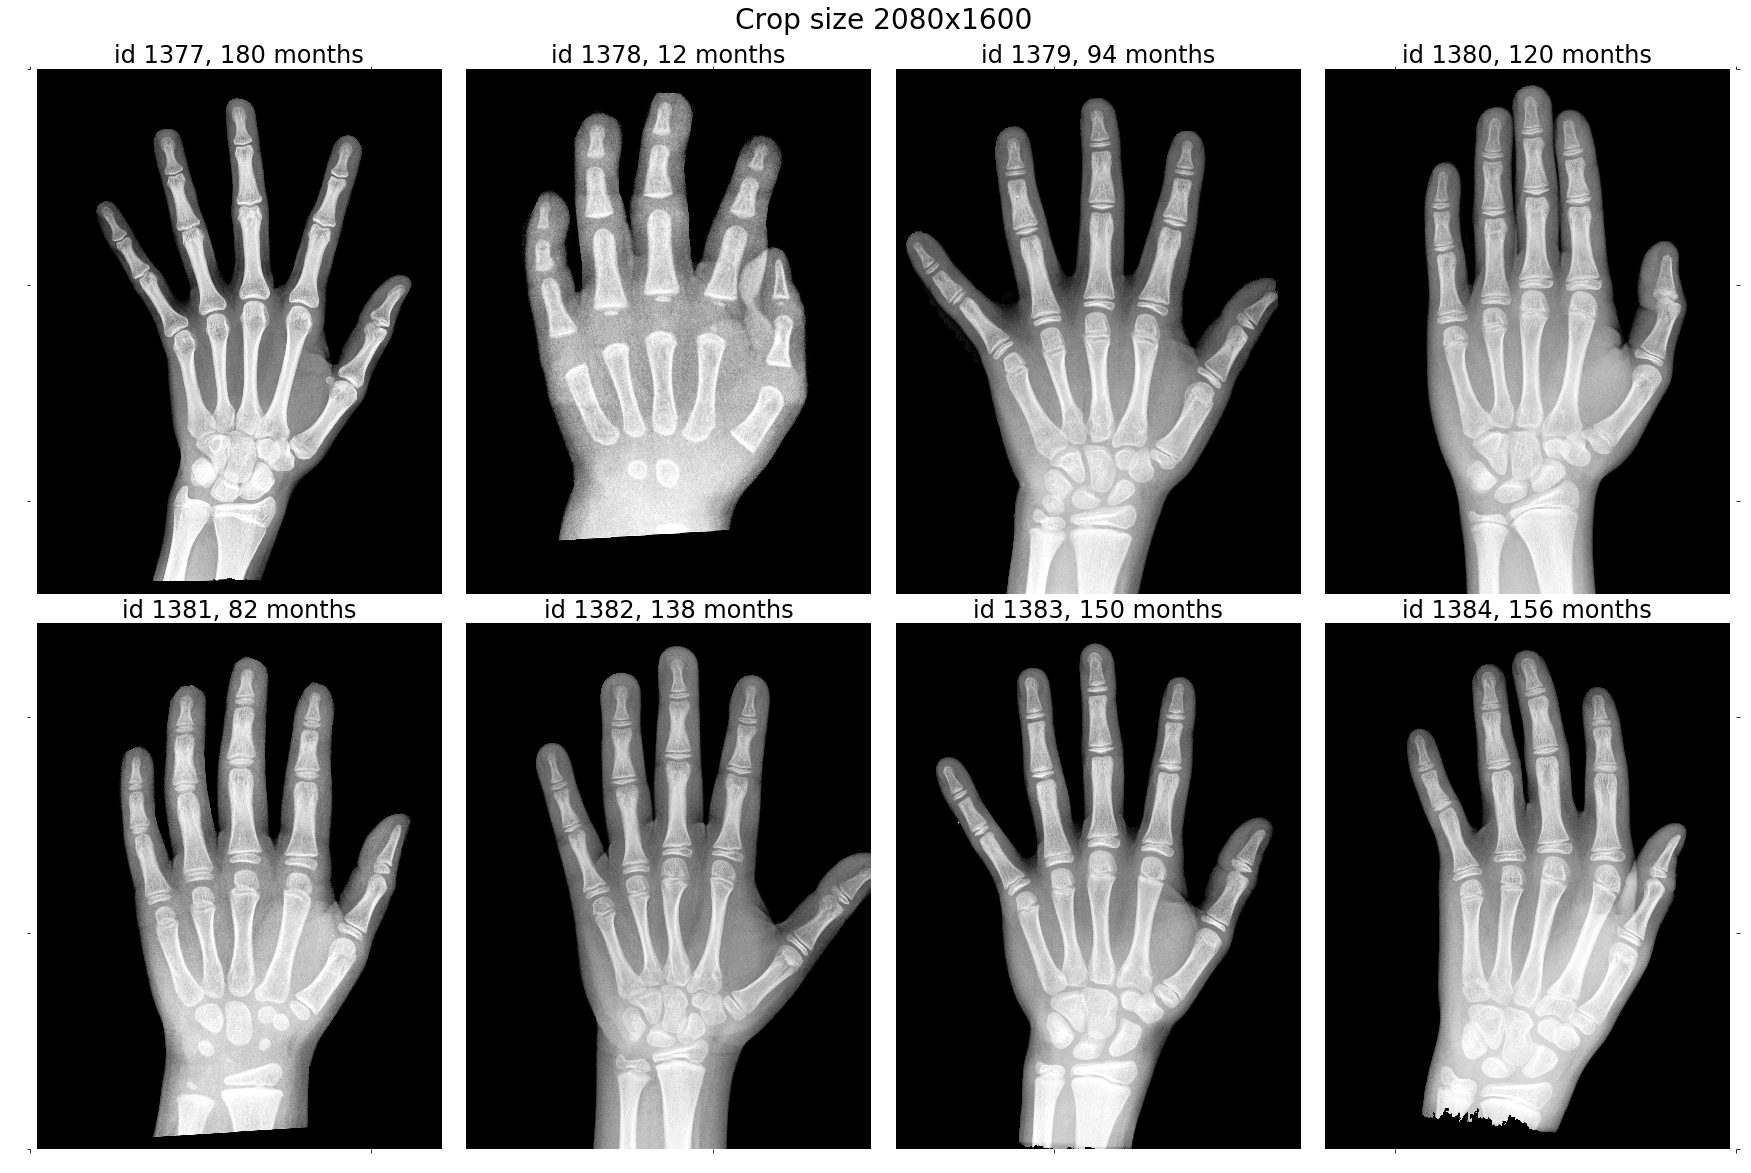

In [5]:
# the preprocessed data is scaled to 2080x1600 (HxW)
boneage_dataset = BoneAgeDataset(bone_age_frame=bone_age_frame, root=image_root, transform=None)

nimages = 8
plot_radiographs(boneage_dataset, nimages)

* ### Familiarize yourself with dataset augmentation

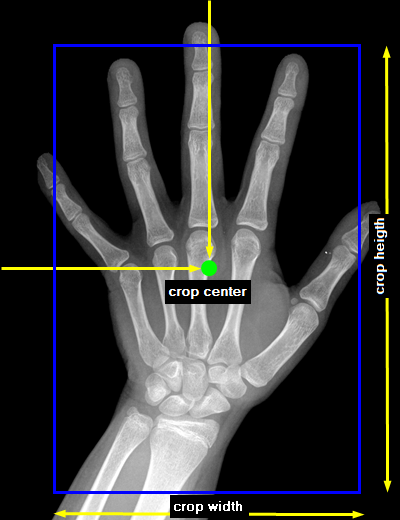

In [6]:
display(Image(DATA_PATH / '1396_crop_area.png', width=400, unconfined=True))

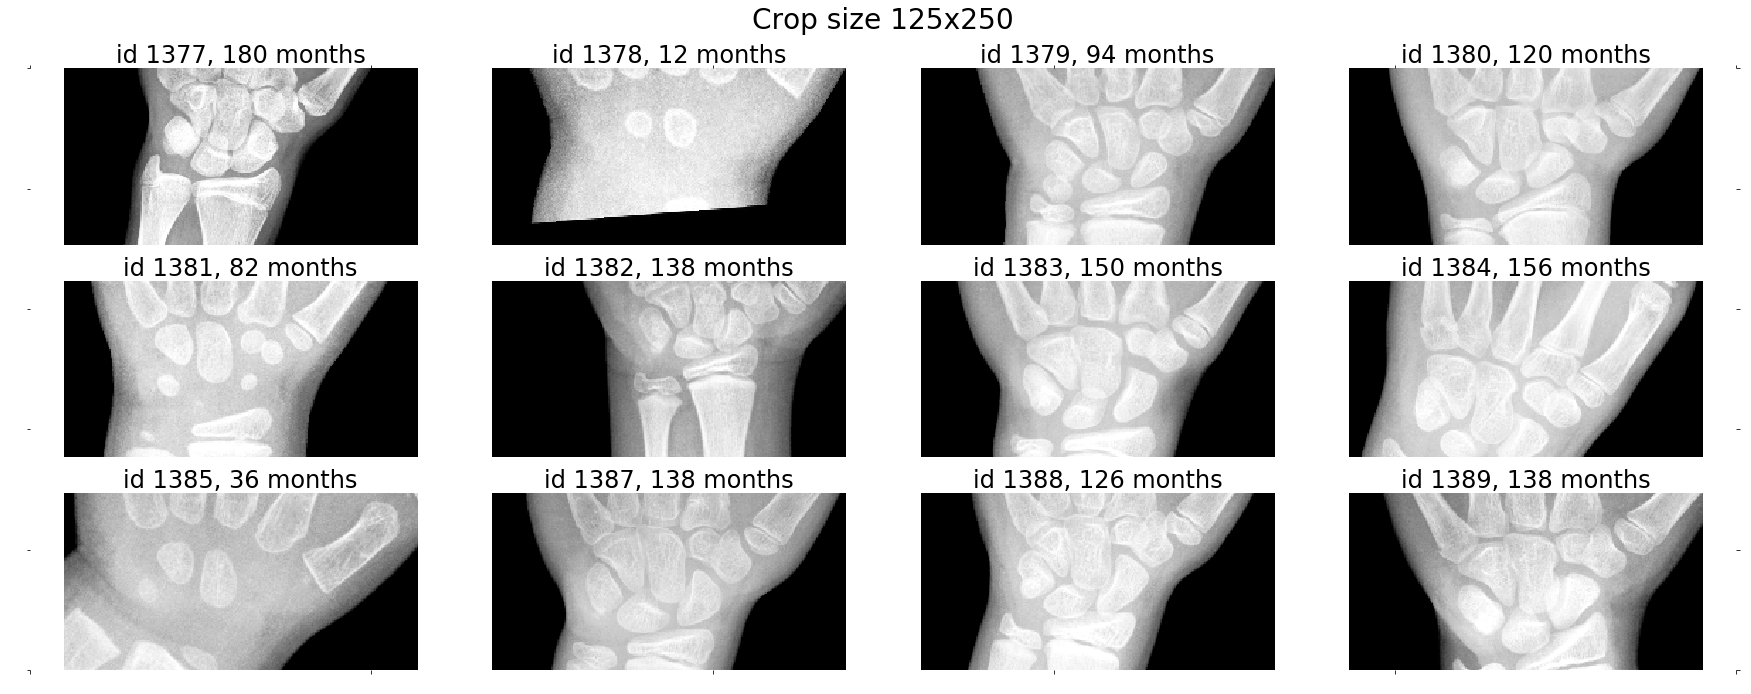

In [7]:
# With `get_transform` function we extract cropped, rescaled and augmented regions of interest
# This allows us to experiment with different areas of a radiograph. See the paper referenced in README
# We also normalize labels by demeaning and rescaling to (120, 120), see `normalize_target` function

# Let's crop just wrist area
crop_center = 1600, 800
crop_size = 500, 1000
scale = 0.25
crop_dict = {'crop_center': crop_center, 'crop_size': crop_size}
train_transform = get_transform(augmentation=True, crop_dict=crop_dict, scale=scale)

boneage_dataset = BoneAgeDataset(bone_age_frame=bone_age_frame, root=image_root,
                                 transform=train_transform, target_transform=normalize_target)
nimages = 12
plot_radiographs(boneage_dataset, nimages)

## Train Bone Age model

In [142]:
# Crop most of the radigraph area and scale it with factor 0.25
# Notice that we use normalized targets. For example, loss=0.06 corresponds to error 7.2 months

sys.argv = ' '
args = get_parser().parse_args()
args.crop_center = 1040, 800
args.crop_size = 2000, 1500
args.scale = 0.25
args.model_type = 'age'
args.dataset_split = 1, 10 # split dataset into 10 folds and use the 1st fold for evaluation and 2-10 for training
args.n_epoch = 1
args.n_workers = 0 # you will probably need to set it to 0 for Jupyter notebook run on Windows
main(args=args)

Input shape 1x500x375 [CxHxW]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 * Epoch (train): 100% 1392/1392 [16:26<00:00,  1.41it/s, loss=0.234]
1/1 * Epoch (valid): 100% 155/155 [00:54<00:00,  2.84it/s, loss=0.163]
[2019-12-03 22:47:58,172] 
1/1 * Epoch 1 (train): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=16.2466 | _timers/batch_time=0.4972 | _timers/data_time=0.4796 | _timers/model_time=0.0176 | loss=0.2641
1/1 * Epoch 1 (valid): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=26.2066 | _timers/batch_time=0.3117 | _timers/data_time=0.2977 | _timers/model_time=0.0140 | loss=0.1884


I1203 22:47:58.172847  4340 logging.py:152] 
1/1 * Epoch 1 (train): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=16.2466 | _timers/batch_time=0.4972 | _timers/data_time=0.4796 | _timers/model_time=0.0176 | loss=0.2641
1/1 * Epoch 1 (valid): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=26.2066 | _timers/batch_time=0.3117 | _timers/data_time=0.2977 | _timers/model_time=0.0140 | loss=0.1884


Top best models:
f:\Sandbox\ml-recipe-bone-age\notebooks\..\results\logs\checkpoints/train.1.pth	0.1884


### Evaluate Bone Age model on test data

In [8]:
crop_center = 1040, 800
h, w = 2000, 1500
scale = 0.25
input_shape = (1, int(h * scale), int(w * scale))
crop_dict = {'crop_center': crop_center, 'crop_size': (h, w)}

# Test dataset
test_frame = pd.read_csv(DATA_PATH / 'test.csv') # ground truth
test_root =  DATA_PATH / 'test'

test_transform = get_transform(augmentation=False, crop_dict=crop_dict, scale=scale)
test_dataset = BoneAgeDataset(bone_age_frame=test_frame, root=test_root, transform=test_transform,
                              target_transform=normalize_target,
                              model_type='age')
data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [9]:
# Load pretrained model
prev_ckpt = MODELS_DIR / 'bone_age.epoch36-err0.059.pth'
checkpoint = convert_checkpoint(prev_ckpt, {'input_shape': input_shape, 'model_type': 'age'})
model = m46.from_ckpt(checkpoint)

Model was loaded from dictionary.


In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
runner = SupervisedRunner(
    input_key='image', output_key='preds',
    input_target_key='label', device=device
)
predictions = runner.predict_loader(
    model, data_loader,
    verbose=False
)

Mean absolute error 7.61 months.


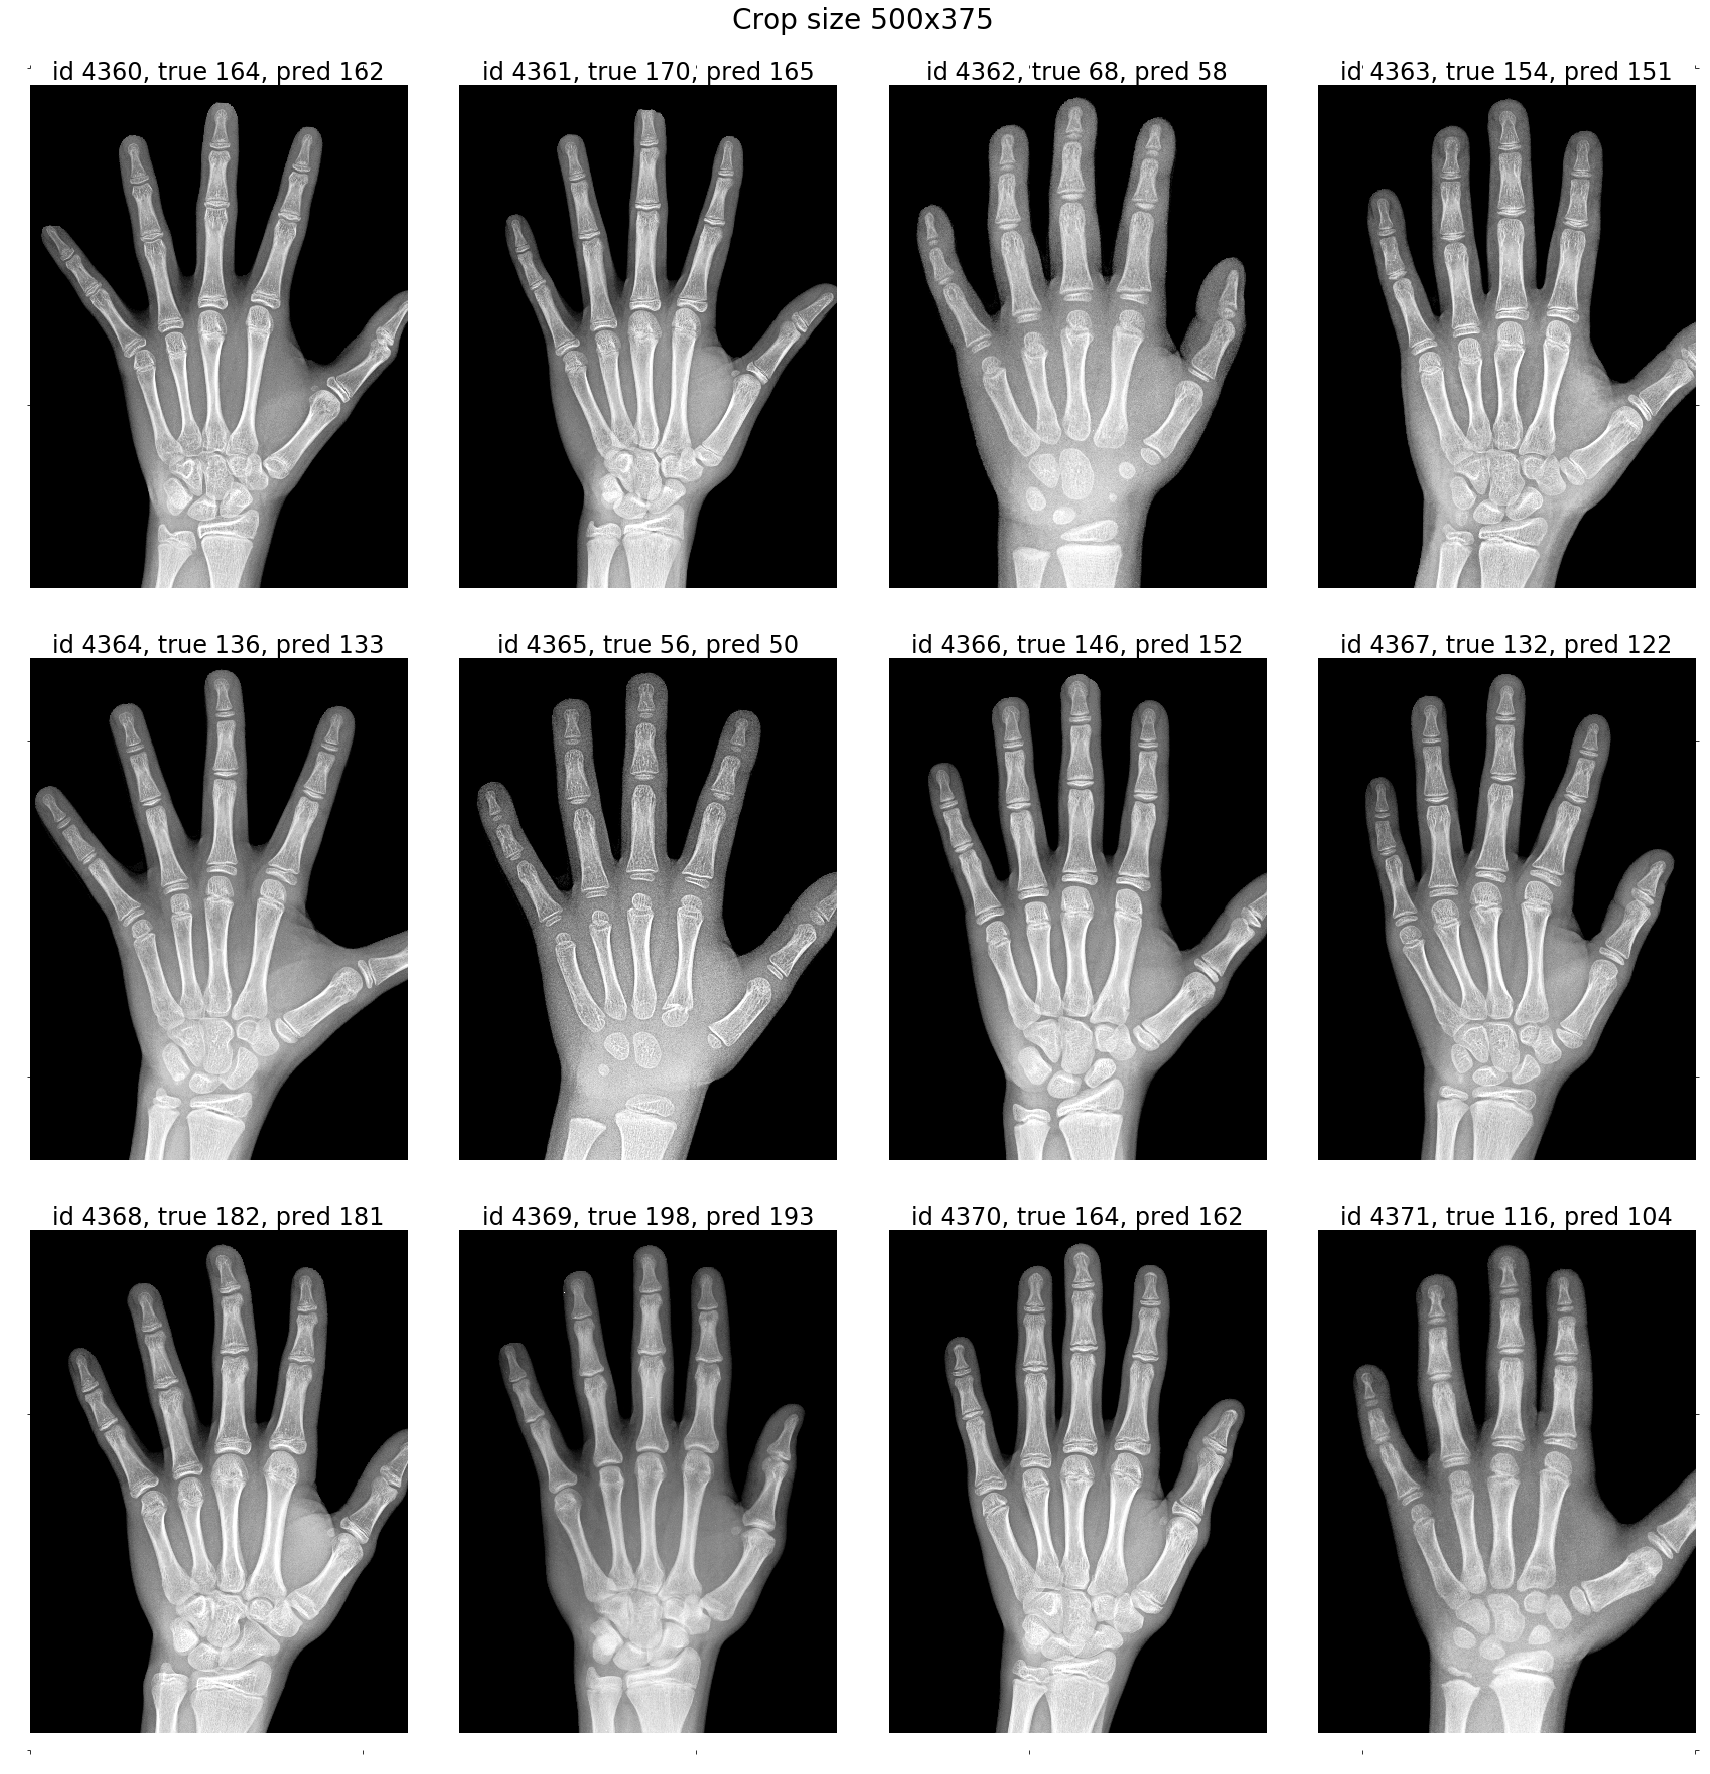

In [13]:
# Plot some predictions
predicted_labels = 120 * (1 + predictions.flatten())
true_labels = test_frame['boneage'].array
mae = np.abs(true_labels - predicted_labels).mean()
print(f'Mean absolute error {mae:0.2f} months.', )

nimages = 12
plot_radiographs(test_dataset, nimages, predictions=predicted_labels)

## Train Gender model

In [143]:
sys.argv = ' '
args = get_parser().parse_args()
args.crop_center = 1040, 800
args.crop_size = 2000, 1500
args.scale = 0.25
args.model_type = 'gender'
args.dataset_split = 1, 10 # split dataset into 10 folds and use the 1st fold for evaluation and 2-10 for training
args.n_epoch = 1
args.n_workers = 0 # you will probably need to set it to 0 for Jupyter notebook run on Windows
main(args=args)

Input shape 1x500x375 [CxHxW]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 * Epoch (train): 100% 1392/1392 [16:10<00:00,  1.43it/s, accuracy01=80.000, loss=0.405]  
1/1 * Epoch (valid): 100% 155/155 [00:51<00:00,  2.98it/s, accuracy01=60.000, loss=0.740]
[2019-12-03 23:07:22,417] 
1/1 * Epoch 1 (train): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=16.5482 | _timers/batch_time=0.4864 | _timers/data_time=0.4687 | _timers/model_time=0.0177 | accuracy01=60.4023 | loss=0.6693
1/1 * Epoch 1 (valid): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=27.7415 | _timers/batch_time=0.2936 | _timers/data_time=0.2806 | _timers/model_time=0.0148 | accuracy01=50.1452 | loss=0.9112


I1203 23:07:22.417249  4340 logging.py:152] 
1/1 * Epoch 1 (train): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=16.5482 | _timers/batch_time=0.4864 | _timers/data_time=0.4687 | _timers/model_time=0.0177 | accuracy01=60.4023 | loss=0.6693
1/1 * Epoch 1 (valid): _base/lr=2.000e-05 | _base/momentum=0.5000 | _timers/_fps=27.7415 | _timers/batch_time=0.2936 | _timers/data_time=0.2806 | _timers/model_time=0.0148 | accuracy01=50.1452 | loss=0.9112


Top best models:
f:\Sandbox\ml-recipe-bone-age\notebooks\..\results\logs\checkpoints/train.1.pth	0.9112


### Evaluate gender model

In [14]:
crop_center = 1040, 800
h, w = 2000, 1500
scale = 0.25
input_shape = (1, int(h * scale), int(w * scale))
crop_dict = {'crop_center': crop_center, 'crop_size': (h, w)}

# Test dataset
test_frame = pd.read_csv(DATA_PATH / 'test.csv') # ground truth
test_root =  DATA_PATH / 'test'

test_transform = get_transform(augmentation=False, crop_dict=crop_dict, scale=scale)
test_dataset = BoneAgeDataset(bone_age_frame=test_frame, root=test_root, transform=test_transform,
                              target_transform=None, # do not normalize target
                              model_type='gender')
data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)

In [15]:
# Load pretrained model
prev_ckpt = MODELS_DIR / 'bone_gender.epoch49-err0.114.pth'
checkpoint = convert_checkpoint(prev_ckpt, {'input_shape': input_shape, 'model_type': 'gender'})
model = m46.from_ckpt(checkpoint)

Model was loaded from dictionary.


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
output_key = 'probs'
runner = SupervisedRunner(
    input_key='image', output_key=output_key,
    input_target_key='label', device=device
)
predictions = runner.predict_loader(
    model, data_loader,
    verbose=False
)

In [17]:
predicted_labels = predictions.flatten().round()
true_labels = test_frame['male'].array * 1
accuracy = (true_labels == predicted_labels).mean()
print(f'Mean accuracy {accuracy:0.2f}.')

Mean accuracy 0.93.
